# Preliminaries

## Dataset

In this set of exercises we will use the same dataset as from [week 3](week_3.ipynb). 


As before, we provide the data already curated in the following two files:

`RNA_expression_curated.csv`: [148 cell lines , 238 genes]

`drug_response_curated.csv`: [148 cell lines , YM155 drug]

The curated data can be read as `pandas` `DataFrame` in the following way:

In [1]:
import pandas as pd

gene_expression = pd.read_csv("./data/RNA_expression_curated.csv", sep=',', header=0, index_col=0)
drug_response = pd.read_csv("./data/drug_response_curated.csv", sep=',', header=0, index_col=0)
lables = pd.read_csv("./data/drug_response_curated.csv", sep=',', header=0, index_col=0)

The goal of the exercises is to train support vector machine (SVM) and random forests classifiers on this dataset and explore and learn about their hyperparameters. 

## Tools

The `scikit-learn` library provides the required tools for support vector machines, as well as for random forest algorithms.

In [2]:
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs, make_circles
from sklearn.metrics import classification_report

Before proceeding, look up the documentation of the imported functions and read about their basic functionality. Below, we list some important parameters of SVMs and random forests that can be tuned during training.

#### Support Vector Machines (SVM)

`C`: error term.

`kernel`: similarity function ('linear', 'poly', 'sigmoid' or 'rbf')

`gamma`: kernel coef. for 'rbf', 'poly' and 'sigmoid' kernels. It can be thought of as the ‘spread’ of the kernel and therefore the decision region.

`degree`: degree for the 'poly' kernel.

`coef0`: independt term in the 'poly' and 'sigmoid' kernels


#### Random Forests

`n_estimators`: number of trees in our random forest.

`max_depth`: maximum number of levels in each decision tree

`max_features`: maximum number of features to consider per split in an individual tree.

`min_sample_leaf`: minimum number of data points per leaf node

`min_samples_split`: minimum number of data points placed in a node before the node is split

`oob_score`: the out-of-bag (OOB) error is the average error for each observation calculated using predictions from the trees that do not contain that observation in their respective bootstrap sample. Set this parameter to true.

`bootstrap`: method for sampling data points (with or without replacement). Set this parameter to true.

`criterion`: function used to measure the quality of the split (e.g. 'entropy' or 'gini')

# Exercises

## Support vector machines

The  `make_blobs` and `make_circles` functions can be used to generate linearly and not linearly separable toy datasets. 

In [3]:
# data generation: linearly separable
X, Y = make_blobs(n_samples=200, centers=2, n_features=2, random_state=1234)
X = pd.DataFrame(X, columns=['x1', 'x2'])

# splitting data into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=333)

The following code illustrates how to train a linear SVM classifier and plot the data points, the separating hyperplane, the support vectors and the margins that pass through them (considering the training data)

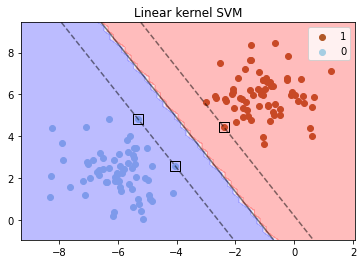

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# build the model
model = svm.SVC(kernel='linear', random_state=33)
model.fit(X_train, Y_train)

# create plot
fig, ax = plt.subplots()

# get colors from qualitative colormap 'Paired'
cmap = plt.cm.get_cmap('Paired')

# plot data points
ax.scatter(X_train.iloc[Y_train == 1, 0], X_train.iloc[Y_train == 1, 1],
           c=[cmap(11)], label='1')
ax.scatter(X_train.iloc[Y_train == 0, 0], X_train.iloc[Y_train == 0, 1],
           c=[cmap(0)], label='0')
ax.legend(loc='best')

# plot the decision function
# create grid to evaluate model
x1_min, x1_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
x2_min, x2_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1

XX, YY = np.meshgrid(np.arange(x1_min, x1_max, .2),
                     np.arange(x2_min, x2_max, .2))

xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# Establish the class for each point in the contour
Z = model.predict(xy).reshape(XX.shape)

# Visualization of the contour
ax.contourf(XX, YY, Z, cmap='bwr', alpha=0.3)

# plot support vectors, whose are responsible for building the margins
ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k', marker='s')

ax.axis([x1_min, x1_max, x2_min, x2_max])
plt.axis('tight')
plt.title('Linear kernel SVM')
plt.show()

Train a radial basis function (RBF) SVM classifier with `gamma=0.5` and plot the results in the same way.

In [5]:
# data generation: not linearly separable
X, Y = make_circles(n_samples=200, noise=0.05, random_state=1234)
X = pd.DataFrame(X, columns=['x1', 'x2'])

# splitting data into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=333)

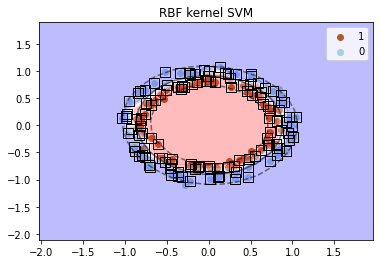

In [6]:
# build the model
model = svm.SVC(kernel='rbf', gamma=0.5, random_state=33)
model.fit(X_train, Y_train)

# create plot
fig, ax = plt.subplots()

# get colors from qualitative colormap 'Paired'
cmap = plt.cm.get_cmap('Paired')

# plot data points
ax.scatter(X_train.iloc[Y_train == 1, 0], X_train.iloc[Y_train == 1, 1],
           c=[cmap(11)], label='1')
ax.scatter(X_train.iloc[Y_train == 0, 0], X_train.iloc[Y_train == 0, 1],
           c=[cmap(0)], label='0')
ax.legend(loc='best')

# plot the decision function
# create grid to evaluate model
x1_min, x1_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
x2_min, x2_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1

XX, YY = np.meshgrid(np.arange(x1_min, x1_max, .2),
                     np.arange(x2_min, x2_max, .2))

xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# Establish the class for each point in the contour
Z = model.predict(xy).reshape(XX.shape)

# Visualization of the contour
ax.contourf(XX, YY, Z, cmap='bwr', alpha=0.3)

# plot support vectors, whose are responsible for building the margins
ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k', marker='s')

ax.axis([x1_min, x1_max, x2_min, x2_max])
plt.axis('tight')
plt.title('RBF kernel SVM')
plt.show()

<p><font color='#770a0a'>When should a RBF kernel be used over a linear kernel? Motivate your answer.</font></p>
<b>Answer:</b> When a linear kernel does not perform well on a large number of features, the RBF kernel can be used to improve the performance.
<p><font color='#770a0a'>Do we need to normalize the data before using a kernel function? Motivate your answer. </font></p>
<b>Answer:</b> Yes, the data needs to be normalized before using the kernel function. All of the components need to have a similar contribution to the Euclidean distance. By normalizing the data, each component will have an equal contribution.

## Predicting drug response on cell lines from gene expression data with SVMs

Explore the hyper-parameter space of an SVM classifier with cross-validation for the Genomics of Drug Sensitivity in Cancer (GDSC) dataset. The`GridSearchCV` function can be used to specify a grid of parameter values with the `param_grid` parameter.

Calculate the precision of your predictions, and compare your calculations with the results of `classification_report`, which displays many classification metrics.

In [7]:
import scipy.stats as stats
x_ex = gene_expression
y_ex = drug_response
zscores = stats.zscore(drug_response)
labels = np.zeros(len(zscores))
for i in range(len(zscores)):
    if zscores[i] >= 0:
        labels[i] = 1
    else:
        labels[i] = 0
X_train, X_test, Y_train, Y_test = train_test_split(x_ex, labels, test_size=0.33, random_state=333)


param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(model,param_grid,refit=True,verbose=2)
grid.fit(X_train,Y_train)
grid_predictions = grid.predict(X_test)
print(grid.best_estimator_)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# Calculate roc auc
roc_value = roc_auc_score(grid_predictions, Y_test)
print("AUC is:", roc_value)

#Get accuracy
acc_value = accuracy_score(grid_predictions, Y_test)
print('Accuracy score is:', acc_value)

#Comparison with classification_report
Y_true, Y_pred = Y_test, grid.predict(X_test)
print(classification_report(Y_true, Y_pred))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1

[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................

[CV] END ...................C=10, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ...................C=10, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ...................C=10, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................

**Answer:** The dataset is a bit imbalanced since it consists of 32 occurences of label 0 and only 17 occurences of label 1. For class 0, the precision (thus the percentage of all instances that were classified as 0 that were correct) was 84%. This is much higher compared to class 1, which only has an precision of 54%. Furthermore, the recall for both classes were not similar, being 66% for class 0 and 76% for class 1. Finally, the f1-score for class 0 is the highest.

## Random forests

Follow the same steps as for SVM. Compare the two algorithms and report which one has better performance.

The random forests classifiers allows to perform feature selection. Evaluate the importance of features extracting the top 50 informative features. A bar plot (`plt.bar()`) can be a useful tool to visualize this. 

In [11]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               oob_score = True
                               )
# Fit on training data
model.fit(X_train, Y_train)

# Actual class predictions
rf_predictions = model.predict(X_test)
# Probabilities for each class
rf_probs = model.predict_proba(X_test)[:, 1]


from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(Y_test, rf_predictions)
print("AUC is:", roc_value)

#Get accuracy
acc_value = accuracy_score(rf_predictions, Y_test)
print('Accuracy score is:', acc_value)

# print prediction results
predictions = model.predict(X_test)
print(classification_report(Y_test, predictions))

AUC is: 0.6847426470588236
Accuracy score is: 0.7142857142857143
              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78        32
         1.0       0.59      0.59      0.59        17

    accuracy                           0.71        49
   macro avg       0.68      0.68      0.68        49
weighted avg       0.71      0.71      0.71        49



**Answer:** Random forests are are a multiclass classifier, whereas SVMs need adaptations to treat multiple classes classification tasks. SVMs can be extended to multiclass classification with a One-Versus-One approach or a One-Versus-All approach. In the first approach, SVMs compare pairs of classes, where in the second approach K SVMs compare one of the K classes to the remaining K-1 classes each time.

SVM performs better on data with linear dependencies. For our models, the accuracy score for Random Forest is higher than the one for SVM. From these results, it can be concluded that this dataset deals with non-lineair dependencies.

Text(0.5, 1.0, '50 most informative features')

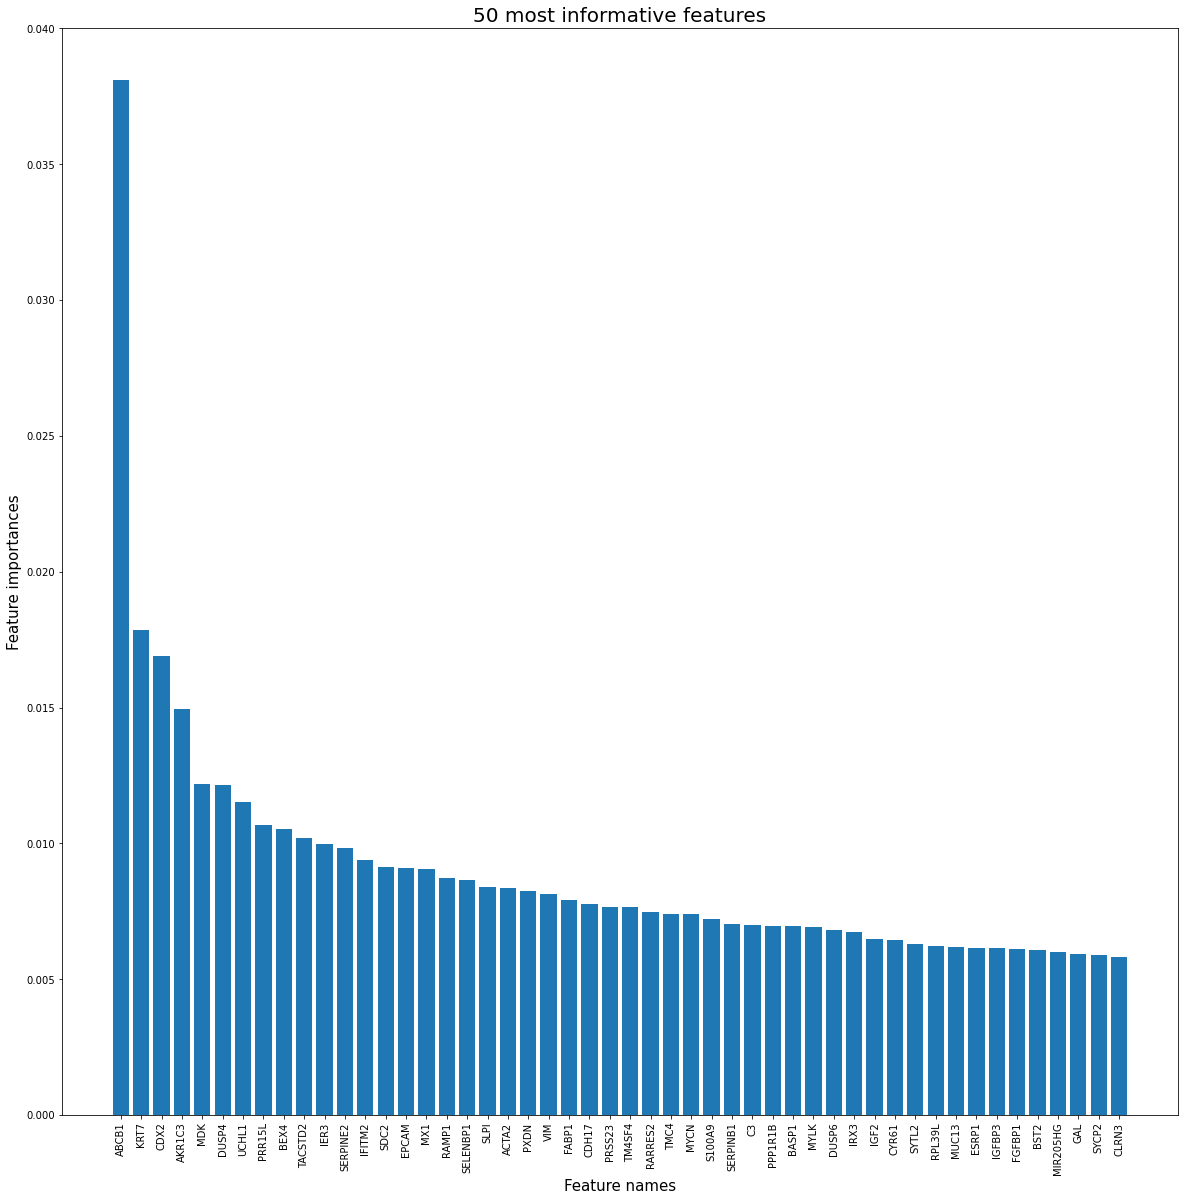

In [9]:
#Feature selection
feat_val = model.feature_importances_
feat_name = X_train.columns

#Initialise data of lists
data = {'Name': feat_name,
        'Value':feat_val}
 
#Create DataFrame
features = pd.DataFrame(data)
feat = features.sort_values('Value', ascending=False)

#Plot
plt.figure(figsize=(20,20))
plt.bar(feat.iloc[0:50,0], feat.iloc[0:50,1])
plt.xticks(rotation = 'vertical')
plt.ylabel('Feature importances', fontsize = 15)
plt.xlabel('Feature names', fontsize = 15)
plt.title('50 most informative features', fontsize = 20)

## Biomedical applications

Driven by technological advances, there has recently been a dramatic increase in availability of biomedical data. Machine learning approaches are well suited to take advantage of this data and have been widely applied to many areas of biology. 

Example of these applications are genome annotation, biomarker identification, systems biology, genome data analysis, protein  function  prediction, protein  structure prediction, protein localization prediction, identification of protein interactions and drug discovery.

SVM and RF methods are among the most popular machine learning methods applied in bioinformatics or computational biology.

Perform a literature search and find a biomedical study in which SVM or RF is applied to obtain certain insights. <p><font color='#770a0a'>Explain the motivation behind using that specific algorithm in the study.
</font></p>

**Answer:** The article of Ram et al. (Ram, Najafi, & Shakeri, 2017) uses random forest (RF) for the classification of microarray data sets. They explain why the RF method is ideal for this problem: RF is suitable for matrix when there are more variables than observations and it is suitable for the 2- and multi-class problems. Furthermore, when most of the predictive variables are noisy, RF still has a good predictive performance, meaning it does not require the selection of genes prior to training, which saves time. They also claim RF does not overfit and that RF can handle both categorical and continuous predictors at the same time and also incorporates interactions among predictor variables, which is needed in microarray classification. They also like that the output of a RF is invariant to monotone transformations of the predictors and that there are already high quality and free implementations for RF available which they can easily apply to their own data. RF returns measures of important variable, which they like. Lastly, they are pleased that there is little need to fine-tune parameters in RF to achieve excellent performance. All these reasons led them to choosing to use RF in their research.

Ram, M., Najafi, A., & Shakeri, M. T. (2017). Classification and Biomarker Genes Selection for Cancer Gene Expression Data Using Random Forest. Iranian Journal of Pathology, 12(4), 339. Retrieved from /pmc/articles/PMC5844678/

